In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j

**Citation:** This notebook is built on the approach used by AnthonyTherrien with modifications to the CYCLEGAN architecture , Loss funtions , optimizers , model training.I have incorporated select sections of code which i have included as an inline comment near the respective section.

Github Link: https://github.com/kmadhu181090/Introduction-to-Deep-Learning/tree/main/Week%205

# 1.Project Description:
In this project, we are provided with a dataset containing photographs and Monet-style images. The objective is to build a Generative Adversarial Network (GAN) capable of transforming photos into Monet-style paintings, ultimately generating over 7,000 stylized images.

To achieve this, I implemented a CycleGAN architecture, which learns bidirectional mappings between the photo and Monet domains without requiring paired examples. The model consists of generator and discriminator. For the discriminator, I used a PatchGAN, which evaluates local image patches to enforce high-frequency realism and texture fidelity.

*File Size:*
Monet Samples - 300
Photo Samples - 7035 
File Format: TFREC and JPEG

**Output:****
7000+ images in jpef format inside images.zip folder




*Basic steps involved in the project:*
Step 1: Import the libraries

Step 2: Load JPEG and TRFEC images and parse them and load the data set 

Step 3: Exploratory data analysis
a)Display Photo and Monet Samples
b)Pixel Intensity Heatmaps
c)Pixel Intensity - Each image
d)Pixel Intensity - Photo and MONET images

Step 4: CYCLEGAN architecture

a)Add Padding and Residual 
b)Normalization
c)Build Generator
d)PatchGAN discriminator

Step 5: Loss Functions:

a)Adversarial Loss
b)Generator Loss
c)Cycle Consistency Loss
d)Identity Loss
e)Generator Total Loss

Step 6:Build optimizers

Step 7:Model Training

Step 8:Running Epochs and displaying the loss for each epoch

Step 9:Generate Monet images 

Step 10:Visualization of the MONET styled images

Step 11:Submissions - images.zip

Step 12:Conclusion

Step 13:References

Step 14:Acknowledgement

# 2.Import the Libraries

In [3]:
#Import Libraries

import os
import math
import random
import glob
import zipfile
from datetime import timedelta


import numpy as np
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [4]:
#This section of code is adapted from AnthonyTherrien's notebook.

#Set Kaggle Path and global variables
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = 256
BATCH_SIZE = 4
EPOCHS = 20
BUFFER_SIZE = 1024
OUTPUT_DIR = 'images'
SEED = 123

# Set seeds
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Detect Kaggle paths
BASE_INPUT = '/kaggle/input/gan-getting-started'
MONET_TFREC = os.path.join(BASE_INPUT, 'monet_tfrec')
PHOTO_TFREC = os.path.join(BASE_INPUT, 'photo_tfrec')
MONET_JPG = os.path.join(BASE_INPUT, 'monet_jpg')
PHOTO_JPG = os.path.join(BASE_INPUT, 'photo_jpg')

#Output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
#Connect to TPU

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.20.0


# 3.Load JPEG and TRFEC images and parse them and load the data set 


In [6]:
#This section of code is adapted from AnthonyTherrien's notebook.
#Parse a single TFRecord image from the file

def tfrec_desc():
    feature_description = {'image':tf.io.FixedLenFeature([],tf.string)}
    return feature_description

#Inspecting TFRecord sample

def tfrec_parse(example_photo):
    features = tf.io.parse_single_example(example_photo, tfrec_desc())
    image = tf.image.decode_jpeg(features['image'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE], method='bicubic')
    image = (image * 2.0) - 1.0
    return image 


#Load TFRecords 

def load_tfrecord(tfrecord_dir):
    pattern = os.path.join(tfrecord_dir, '*.tfrec')
    files = tf.io.gfile.glob(pattern)
    dataset = tf.data.TFRecordDataset(files, num_parallel_reads=AUTOTUNE)
    dataset = dataset.map(tfrec_parse, num_parallel_calls=AUTOTUNE)
    return dataset


#Load jpg dataset
def load_jpg(jpg_dir):
    pattern = os.path.join(jpg_dir, '*.jpg')
    files = tf.io.gfile.glob(pattern)
    path_ds = tf.data.Dataset.from_tensor_slices(files)
    def _load(path):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE], method='bicubic')
        image = (image * 2.0) - 1.0
        return image
    dataset = path_ds.map(_load, num_parallel_calls=AUTOTUNE)
    return dataset

#Load datasets

monet_ds = load_tfrecord(MONET_TFREC) if tf.io.gfile.exists(MONET_TFREC) else load_jpg(MONET_JPG)
photo_ds = load_tfrecord(PHOTO_TFREC) if tf.io.gfile.exists(PHOTO_TFREC) else load_jpg(PHOTO_JPG)

monet_ds_train = monet_ds.shuffle(BUFFER_SIZE, seed=SEED).batch(BATCH_SIZE).prefetch(AUTOTUNE)
photo_ds_train = photo_ds.shuffle(BUFFER_SIZE, seed=SEED).batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = tf.data.Dataset.zip((photo_ds_train, monet_ds_train))
train_ds = train_ds.prefetch(AUTOTUNE)

2025-10-31 17:42:42.361989: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# 4.Exploratory Data Analysis

In [7]:
#Display Data sizes

print('Monet samples (approx):', sum(1 for _ in monet_ds.take(5)) * (len(list(tf.io.gfile.glob(os.path.join(MONET_JPG, '*.jpg')))) // 5 if tf.io.gfile.exists(MONET_JPG) else BATCH_SIZE))
print('Photo samples (approx):', sum(1 for _ in photo_ds.take(5)) * (len(list(tf.io.gfile.glob(os.path.join(PHOTO_JPG, '*.jpg')))) // 5 if tf.io.gfile.exists(PHOTO_JPG) else BATCH_SIZE))

Monet samples (approx): 300
Photo samples (approx): 7035


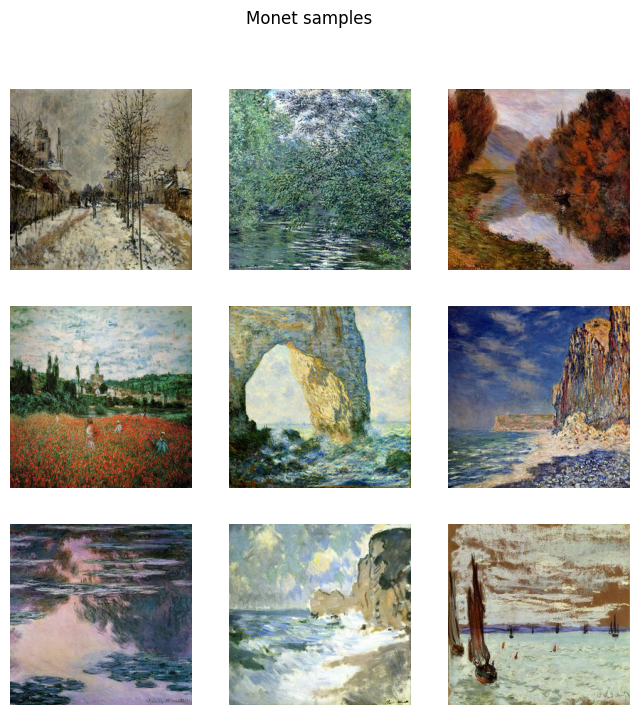

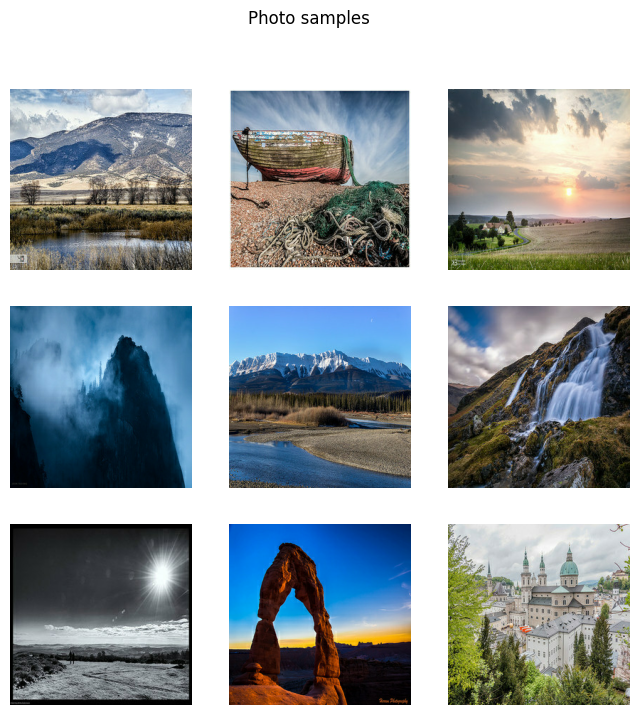

In [8]:
#Photos and Monet images Visualization
import matplotlib.pyplot as plt


def show_batch(dataset, title):
    images = next(iter(dataset.unbatch().batch(9)))
    plt.figure(figsize=(8,8))
    for i in range(min(9, images.shape[0])):
        plt.subplot(3,3,i+1)
        img = (images[i].numpy() + 1.0) / 2.0
        plt.imshow(np.clip(img, 0, 1))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Show Monet samples
show_batch(monet_ds.batch(9), 'Monet samples')

# Show Photo samples
show_batch(photo_ds.batch(9), 'Photo samples')

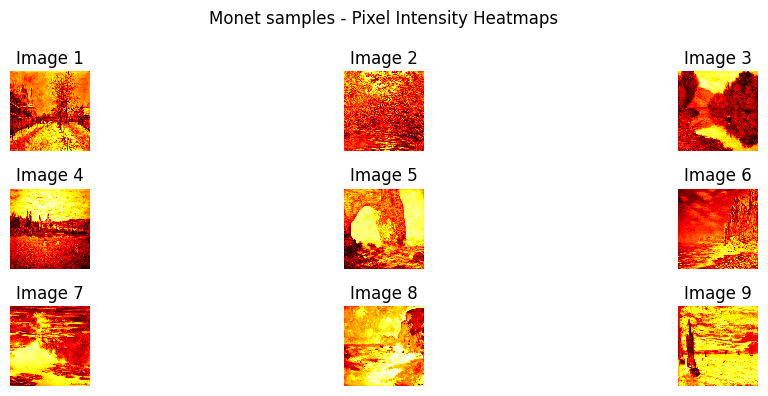

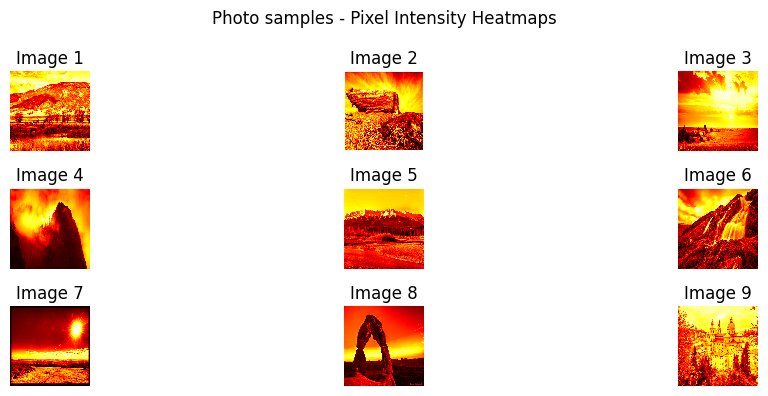

In [9]:
#Pixel Intensity HeatMap

def show_pixel_intensity(dataset, title):
    import numpy as np
    images = next(iter(dataset.unbatch().batch(9)))
    plt.figure(figsize=(12, 4))
    
    for i in range(min(9, images.shape[0])):
        img = (images[i].numpy() + 1.0) / 2.0  # Rescale from [-1, 1] to [0, 1]
        gray = np.mean(img, axis=-1)  # Convert to grayscale for intensity
        
        plt.subplot(3, 3, i+1)
        plt.imshow(gray, cmap='hot', interpolation='nearest')
        plt.title(f'Image {i+1}')
        plt.axis('off')
    
    plt.suptitle(f'{title} - Pixel Intensity Heatmaps')
    plt.tight_layout()
    plt.show()


show_pixel_intensity(monet_ds.batch(9), 'Monet samples')
show_pixel_intensity(photo_ds.batch(9), 'Photo samples')

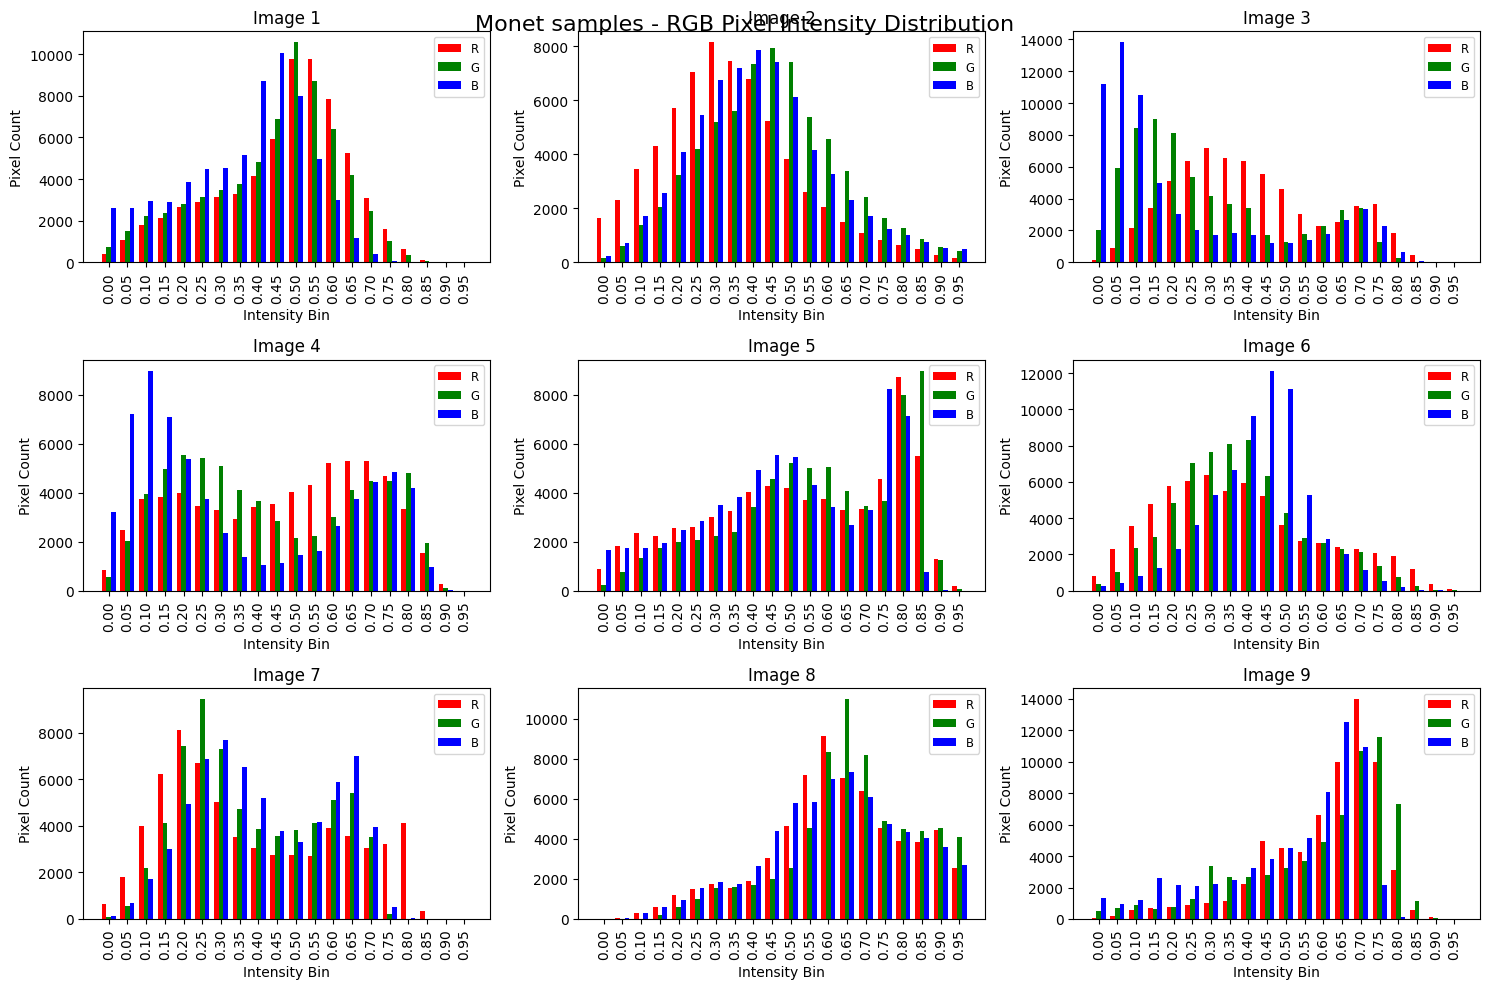

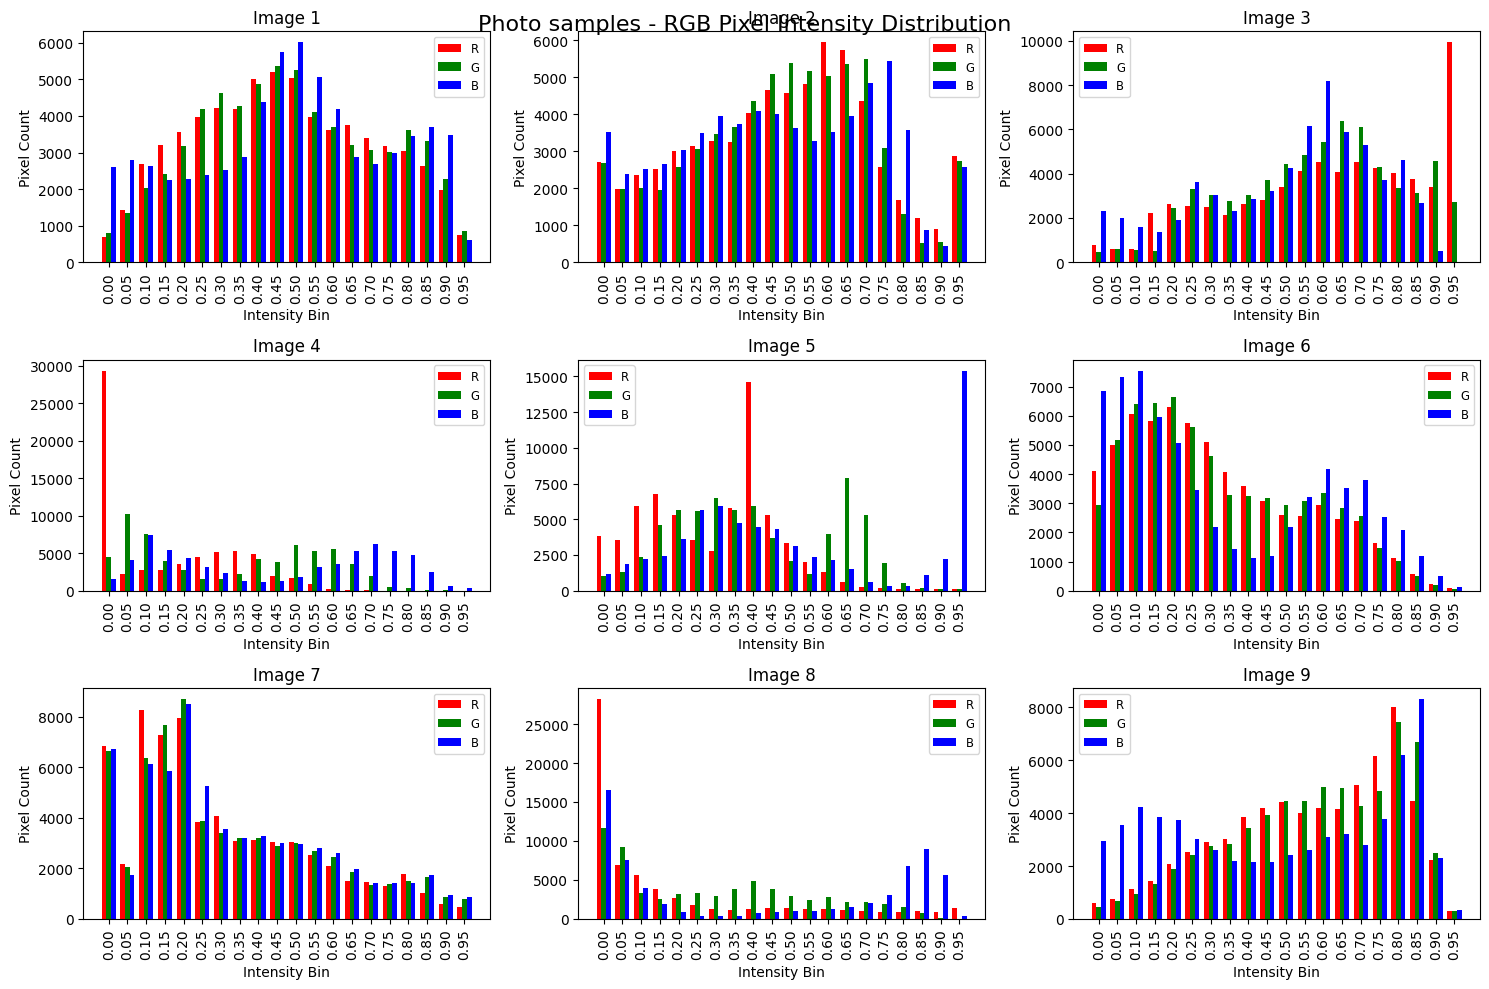

In [11]:
#RGB Pixel Intensity of few sample images

def show_rgb_intensity_barplot(dataset, title):
    import numpy as np
    import matplotlib.pyplot as plt

    images = next(iter(dataset.unbatch().batch(9)))
    plt.figure(figsize=(15, 10))

    for i in range(min(9, images.shape[0])):
        img = (images[i].numpy() + 1.0) / 2.0  # Rescale from [-1, 1] to [0, 1]
        r, g, b = img[..., 0].flatten(), img[..., 1].flatten(), img[..., 2].flatten()

        bins = np.linspace(0, 1, 21)  # 20 bins from 0 to 1
        r_hist, _ = np.histogram(r, bins=bins)
        g_hist, _ = np.histogram(g, bins=bins)
        b_hist, _ = np.histogram(b, bins=bins)

        plt.subplot(3, 3, i+1)
        bar_width = 0.25
        x = np.arange(len(r_hist))
        plt.bar(x - bar_width, r_hist, width=bar_width, color='red', label='R')
        plt.bar(x, g_hist, width=bar_width, color='green', label='G')
        plt.bar(x + bar_width, b_hist, width=bar_width, color='blue', label='B')
        plt.title(f'Image {i+1}')
        plt.xlabel('Intensity Bin')
        plt.ylabel('Pixel Count')
        plt.xticks(x, [f'{b:.2f}' for b in bins[:-1]], rotation=90)
        plt.legend(fontsize='small')
        plt.tight_layout()

    plt.suptitle(f'{title} - RGB Pixel Intensity Distribution', fontsize=16)
    plt.show()


show_rgb_intensity_barplot(monet_ds.batch(9), 'Monet samples')


show_rgb_intensity_barplot(photo_ds.batch(9), 'Photo samples')


Photo Dataset RGB Histogram (bin counts):
Bin 1 (0.00-0.05): R=42857723, G=26358176, B=53958150
Bin 2 (0.05-0.10): R=27422075, G=25760361, B=35701752
Bin 3 (0.10-0.15): R=29994744, G=30324242, B=33947238
Bin 4 (0.15-0.20): R=28772415, G=30001444, B=29452094
Bin 5 (0.20-0.25): R=31174700, G=33158297, B=29766653
Bin 6 (0.25-0.30): R=30390855, G=32517140, B=27755024
Bin 7 (0.30-0.35): R=29145171, G=31824230, B=25837471
Bin 8 (0.35-0.40): R=25683177, G=28440967, B=22179472
Bin 9 (0.40-0.45): R=26260819, G=29496886, B=22771300
Bin 10 (0.45-0.50): R=24714997, G=28325292, B=21628573
Bin 11 (0.50-0.55): R=23316577, G=26840213, B=20797307
Bin 12 (0.55-0.60): R=20509762, G=23056044, B=18534151
Bin 13 (0.60-0.65): R=20945426, G=23408507, B=19811610
Bin 14 (0.65-0.70): R=19568268, G=21540063, B=19175355
Bin 15 (0.70-0.75): R=17976934, G=19145236, B=18398121
Bin 16 (0.75-0.80): R=15075031, G=15052994, B=16093992
Bin 17 (0.80-0.85): R=14471105, G=13364744, B=15918827
Bin 18 (0.85-0.90): R=11984184,

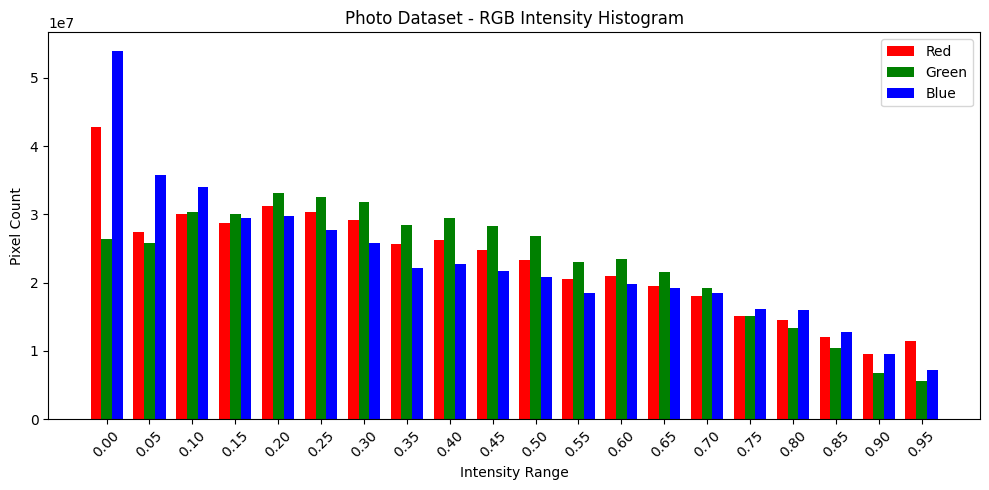


Monet Dataset RGB Histogram (bin counts):
Bin 1 (0.00-0.05): R=241101, G=155323, B=502398
Bin 2 (0.05-0.10): R=360083, G=322453, B=719273
Bin 3 (0.10-0.15): R=560490, G=550188, B=963658
Bin 4 (0.15-0.20): R=681710, G=668399, B=1039442
Bin 5 (0.20-0.25): R=913745, G=875187, B=1195250
Bin 6 (0.25-0.30): R=1089677, G=1037940, B=1192684
Bin 7 (0.30-0.35): R=1226845, G=1167442, B=1184536
Bin 8 (0.35-0.40): R=1195848, G=1160267, B=1085935
Bin 9 (0.40-0.45): R=1332582, G=1344354, B=1190701
Bin 10 (0.45-0.50): R=1358601, G=1428154, B=1234994
Bin 11 (0.50-0.55): R=1374450, G=1525891, B=1249365
Bin 12 (0.55-0.60): R=1300885, G=1455615, B=1151996
Bin 13 (0.60-0.65): R=1423897, G=1527223, B=1269695
Bin 14 (0.65-0.70): R=1469673, G=1509807, B=1279299
Bin 15 (0.70-0.75): R=1457305, G=1473207, B=1263390
Bin 16 (0.75-0.80): R=1212979, G=1234877, B=1033543
Bin 17 (0.80-0.85): R=1153688, G=1081183, B=853484
Bin 18 (0.85-0.90): R=784974, G=695511, B=619249
Bin 19 (0.90-0.95): R=375775, G=331766, B=41269

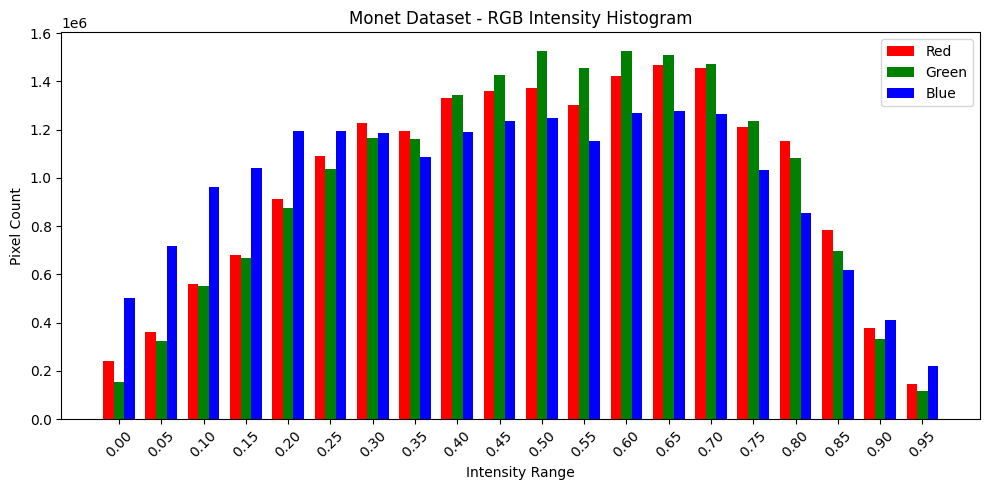

In [12]:
#RGB Pixel intensity distribution

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def compute_rgb_histogram(dataset, name, bins=20):
    r_vals, g_vals, b_vals = [], [], []

    for img_batch in dataset:
        img = img_batch.numpy()
        img = (img + 1.0) / 2.0  # Rescale from [-1, 1] to [0, 1]
        r_vals.extend(img[..., 0].flatten())
        g_vals.extend(img[..., 1].flatten())
        b_vals.extend(img[..., 2].flatten())

    r_vals, g_vals, b_vals = np.array(r_vals), np.array(g_vals), np.array(b_vals)
    bin_edges = np.linspace(0, 1, bins + 1)

    r_hist, _ = np.histogram(r_vals, bins=bin_edges)
    g_hist, _ = np.histogram(g_vals, bins=bin_edges)
    b_hist, _ = np.histogram(b_vals, bins=bin_edges)

    print(f"\n{name} RGB Histogram (bin counts):")
    for i in range(bins):
        print(f"Bin {i+1} ({bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}): "
              f"R={r_hist[i]}, G={g_hist[i]}, B={b_hist[i]}")

    x = np.arange(bins)
    bar_width = 0.25
    plt.figure(figsize=(10, 5))
    plt.bar(x - bar_width, r_hist, width=bar_width, color='red', label='Red')
    plt.bar(x, g_hist, width=bar_width, color='green', label='Green')
    plt.bar(x + bar_width, b_hist, width=bar_width, color='blue', label='Blue')
    plt.xticks(x, [f'{bin_edges[i]:.2f}' for i in range(bins)], rotation=45)
    plt.xlabel('Intensity Range')
    plt.ylabel('Pixel Count')
    plt.title(f'{name} - RGB Intensity Histogram')
    plt.legend()
    plt.tight_layout()
    plt.show()


compute_rgb_histogram(photo_ds.unbatch(), 'Photo Dataset')
compute_rgb_histogram(monet_ds.unbatch(), 'Monet Dataset')

These plots show how the pixel intensities are distributed across the Red,Green and blue channels in the photo and Monet dataset.

In the first plot, Blue dominates the lower intensity ranges while red and green are more evenly spread across mid to high intensities.The chart reveals a balanced color composition with a slight bias towards low intensity range.

In the second plot,Green dominates a little bit higher than the other 2 colors.

# 5.CYCLEGAN Architecture

In [8]:
#CycleGAN Architecture

#Add Padding to prevent the loss of data around the edges

class ReflectionPadding2D(layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)
        if isinstance(padding, int):
            self.padding = ((padding, padding), (padding, padding))
        elif isinstance(padding, (list, tuple)) and len(padding) == 2:
            self.padding = ((padding[0], padding[0]), (padding[1], padding[1]))
        else:
            raise ValueError("Padding must be int or tuple of two ints")

    def call(self, inputs):
        return tf.pad(inputs,
                      [[0, 0],
                       [self.padding[0][0], self.padding[0][1]],
                       [self.padding[1][0], self.padding[1][1]],
                       [0, 0]],
                      mode='REFLECT')

    def get_config(self):
        config = super(ReflectionPadding2D, self).get_config()
        config.update({"padding": self.padding})
        return config

In [9]:
#Residual block
#Input - Downsample - Residual blocks - Upsample - Output
#

def residual_block(x, filters):
    y = ReflectionPadding2D((1,1))(x)  #Applies reflection padding
    y = layers.Conv2D(filters, 3, strides=1, padding='valid')(y)
    y = InstanceNormalization()(y)  #Normalizes with Instance Norm
    y = layers.Activation('relu')(y) #ReLu activation
    y = ReflectionPadding2D((1,1))(y)
    y = layers.Conv2D(filters, 3, strides=1, padding='valid')(y)
    y = InstanceNormalization()(y)
    y = layers.add([x, y]) #adds the input back tothe output
    return y

In [10]:
#Customize instance Normalization layers
from tensorflow.keras import layers

class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        channels = input_shape[-1]
        # Learnable scale and shift parameters
        self.gamma = self.add_weight(
            shape=(channels,),
            initializer="ones",
            trainable=True,
            name="gamma"
        )
        self.beta = self.add_weight(
            shape=(channels,),
            initializer="zeros",
            trainable=True,
            name="beta"
        )

    def call(self, inputs):
        # Compute mean and variance across spatial dimensions (H, W)
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

In [11]:
#Build Generator

def build_generator(input_shape=(256, 256, 3), filters=64, num_res_blocks=9):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial block
    x = ReflectionPadding2D((3, 3))(inputs)
    x = layers.Conv2D(filters, 7, strides=1, padding='valid')(x)
    x = InstanceNormalization()(x)
    x = layers.Activation('relu')(x)

    # Downsampling
    x = layers.Conv2D(filters * 2, 3, strides=2, padding='same')(x)
    x = layers.Conv2D(filters * 4, 3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.Activation('relu')(x)

    # Residual blocks
    for _ in range(num_res_blocks):
        x = residual_block(x, filters * 4)

    # Upsampling
    x = layers.Conv2DTranspose(filters * 2, 3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2DTranspose(filters, 3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.Activation('relu')(x)

    # Final block
    x = ReflectionPadding2D((3, 3))(x)
    x = layers.Conv2D(3, 7, strides=1, padding='valid')(x)
    outputs = layers.Activation('tanh')(x)

    return tf.keras.Model(inputs, outputs, name="CycleGANGenerator")

In [12]:
#PATCHGAN Discriminator

import tensorflow as tf
from tensorflow.keras import layers

def build_discriminator(input_shape=(256, 256, 3), filters=64):
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(filters, 4, strides=2, padding='same', kernel_initializer=initializer)(inputs)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(filters * 2, 4, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(filters * 4, 4, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(filters * 8, 4, strides=1, padding='same', kernel_initializer=initializer)(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(1, 4, strides=1, padding='same', kernel_initializer=initializer)(x)

    return tf.keras.Model(inputs, x, name="PatchGANDiscriminator")


# 6.Loss Functions

In [13]:
#Loss Functions

# Adversarial loss (Least Squares GAN)
def discriminator_loss(real, generated):
    real_loss = tf.reduce_mean(tf.square(real - 1.0))
    generated_loss = tf.reduce_mean(tf.square(generated))
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return tf.reduce_mean(tf.square(generated - 1.0))

In [14]:
#Cycle Consistency Loss - L1 between original and cycled image

def cycle_consistency_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))
    
#Identity Loss - L1 between real image and its identity mapped output

def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image))

In [15]:
#Loss scales

LAMBDA_CYCLE = 10.0
LAMBDA_IDENTITY = 0.5 * LAMBDA_CYCLE

In [16]:
#Generator Total Loss

def total_generator_loss(disc_generated_output, gen_output, target_image, identity_output):
    adv_loss = generator_loss(disc_generated_output)
    cycle_loss = cycle_consistency_loss(target_image, gen_output)
    id_loss = identity_loss(target_image, identity_output)
    return adv_loss + LAMBDA_CYCLE * cycle_loss + LAMBDA_IDENTITY * id_loss

# 7.Build Optimizers

In [17]:
#Build Models under distribution strategy

strategy = tf.distribute.get_strategy()

with strategy.scope():
    generator_g = build_generator()  # Monet → Photo
    generator_f = build_generator()  # Photo → Monet
    discriminator_x = build_discriminator()  # Discriminate Photo
    discriminator_y = build_discriminator()  # Discriminate Monet

    gen_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    gen_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    disc_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    disc_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# 8.Model Training 

In [18]:
#Training 

@tf.function
def train_step(real_x, real_y):
    # real_x: photo, real_y: monet

    with tf.GradientTape(persistent=True) as tape:
        # Forward cycle: Monet → Photo → Monet
        fake_x = generator_g(real_y, training=True)
        cycled_y = generator_f(fake_x, training=True)

        # Backward cycle: Photo → Monet → Photo
        fake_y = generator_f(real_x, training=True)
        cycled_x = generator_g(fake_y, training=True)

        # Identity mapping
        same_x = generator_g(real_x, training=True)
        same_y = generator_f(real_y, training=True)

        # Discriminator outputs
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Generator losses
        gen_g_adv_loss = generator_loss(disc_fake_x)
        gen_f_adv_loss = generator_loss(disc_fake_y)

        gen_g_cycle_loss = cycle_consistency_loss(real_y, cycled_y)
        gen_f_cycle_loss = cycle_consistency_loss(real_x, cycled_x)

        gen_g_id_loss = identity_loss(real_x, same_x)
        gen_f_id_loss = identity_loss(real_y, same_y)

        total_gen_g_loss = gen_g_adv_loss + LAMBDA_CYCLE * gen_g_cycle_loss + LAMBDA_IDENTITY * gen_g_id_loss
        total_gen_f_loss = gen_f_adv_loss + LAMBDA_CYCLE * gen_f_cycle_loss + LAMBDA_IDENTITY * gen_f_id_loss

        # Discriminator losses
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Apply gradients
    generator_g_grads = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_grads = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_grads = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_grads = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    gen_g_optimizer.apply_gradients(zip(generator_g_grads, generator_g.trainable_variables))
    gen_f_optimizer.apply_gradients(zip(generator_f_grads, generator_f.trainable_variables))
    disc_x_optimizer.apply_gradients(zip(discriminator_x_grads, discriminator_x.trainable_variables))
    disc_y_optimizer.apply_gradients(zip(discriminator_y_grads, discriminator_y.trainable_variables))

    return {
        "gen_g_loss": total_gen_g_loss,
        "gen_f_loss": total_gen_f_loss,
        "disc_x_loss": disc_x_loss,
        "disc_y_loss": disc_y_loss,
        "gen_g_adv": gen_g_adv_loss,
        "gen_f_adv": gen_f_adv_loss,
        "gen_g_cycle": gen_g_cycle_loss,
        "gen_f_cycle": gen_f_cycle_loss,
        "gen_g_id": gen_g_id_loss,
        "gen_f_id": gen_f_id_loss
    }

# 9.Epochs and displaying the loss for each epoch

In [19]:
from tqdm import trange

def train(dataset, epochs=EPOCHS):
    for epoch in trange(epochs, desc="Training Epochs"):
        dataset_iter = iter(dataset)  # Create a fresh iterator
        real_x, real_y = next(dataset_iter)  # Only step 0

        losses = train_step(real_x, real_y)

        print(
            f"Epoch {epoch+1:02d} | Step 0000 | "
            f"G={losses['gen_g_loss']:.3f} F={losses['gen_f_loss']:.3f} | "
            f"Dx={losses['disc_x_loss']:.3f} Dy={losses['disc_y_loss']:.3f} | "
            f"CycleG={losses['gen_g_cycle']:.3f} CycleF={losses['gen_f_cycle']:.3f} | "
            f"IdG={losses['gen_g_id']:.3f} IdF={losses['gen_f_id']:.3f}"
        )

In [20]:
train(train_ds, epochs=20)

Training Epochs:   5%|▌         | 1/20 [00:35<11:12, 35.40s/it]

Epoch 01 | Step 0000 | G=12.577 F=14.052 | Dx=2.150 Dy=3.261 | CycleG=0.624 CycleF=0.662 | IdG=0.650 IdF=0.613


Training Epochs:  10%|█         | 2/20 [00:44<05:53, 19.66s/it]

Epoch 02 | Step 0000 | G=10.541 F=13.356 | Dx=10.488 Dy=7.540 | CycleG=0.577 CycleF=0.575 | IdG=0.537 IdF=0.554


Training Epochs:  15%|█▌        | 3/20 [00:52<04:06, 14.50s/it]

Epoch 03 | Step 0000 | G=11.407 F=10.638 | Dx=2.008 Dy=2.059 | CycleG=0.595 CycleF=0.570 | IdG=0.565 IdF=0.605


Training Epochs:  20%|██        | 4/20 [01:00<03:11, 11.94s/it]

Epoch 04 | Step 0000 | G=14.431 F=11.162 | Dx=4.159 Dy=1.588 | CycleG=0.635 CycleF=0.613 | IdG=0.632 IdF=0.654


Training Epochs:  25%|██▌       | 5/20 [01:08<02:39, 10.63s/it]

Epoch 05 | Step 0000 | G=9.934 F=10.290 | Dx=1.305 Dy=1.715 | CycleG=0.580 CycleF=0.558 | IdG=0.557 IdF=0.583


Training Epochs:  30%|███       | 6/20 [01:16<02:16,  9.77s/it]

Epoch 06 | Step 0000 | G=10.039 F=10.081 | Dx=1.495 Dy=1.600 | CycleG=0.590 CycleF=0.526 | IdG=0.517 IdF=0.586


Training Epochs:  35%|███▌      | 7/20 [01:25<02:01,  9.32s/it]

Epoch 07 | Step 0000 | G=9.672 F=10.281 | Dx=1.385 Dy=1.755 | CycleG=0.560 CycleF=0.534 | IdG=0.520 IdF=0.547


Training Epochs:  40%|████      | 8/20 [01:33<01:48,  9.06s/it]

Epoch 08 | Step 0000 | G=10.338 F=10.377 | Dx=1.945 Dy=1.924 | CycleG=0.558 CycleF=0.525 | IdG=0.500 IdF=0.549


Training Epochs:  45%|████▌     | 9/20 [01:41<01:36,  8.80s/it]

Epoch 09 | Step 0000 | G=10.079 F=10.560 | Dx=1.484 Dy=1.647 | CycleG=0.589 CycleF=0.534 | IdG=0.467 IdF=0.588


Training Epochs:  50%|█████     | 10/20 [01:49<01:24,  8.48s/it]

Epoch 10 | Step 0000 | G=9.613 F=9.788 | Dx=1.215 Dy=1.204 | CycleG=0.541 CycleF=0.555 | IdG=0.531 IdF=0.538


Training Epochs:  55%|█████▌    | 11/20 [01:57<01:15,  8.39s/it]

Epoch 11 | Step 0000 | G=8.795 F=8.634 | Dx=0.988 Dy=0.819 | CycleG=0.513 CycleF=0.516 | IdG=0.511 IdF=0.513


Training Epochs:  60%|██████    | 12/20 [02:05<01:05,  8.14s/it]

Epoch 12 | Step 0000 | G=7.920 F=7.973 | Dx=0.857 Dy=0.798 | CycleG=0.460 CycleF=0.480 | IdG=0.471 IdF=0.459


Training Epochs:  65%|██████▌   | 13/20 [02:13<00:56,  8.12s/it]

Epoch 13 | Step 0000 | G=7.298 F=7.508 | Dx=0.776 Dy=0.784 | CycleG=0.421 CycleF=0.457 | IdG=0.454 IdF=0.432


Training Epochs:  70%|███████   | 14/20 [02:21<00:48,  8.09s/it]

Epoch 14 | Step 0000 | G=7.367 F=7.625 | Dx=0.674 Dy=0.653 | CycleG=0.428 CycleF=0.483 | IdG=0.478 IdF=0.424


Training Epochs:  75%|███████▌  | 15/20 [02:29<00:40,  8.04s/it]

Epoch 15 | Step 0000 | G=6.767 F=6.763 | Dx=0.660 Dy=0.688 | CycleG=0.403 CycleF=0.408 | IdG=0.412 IdF=0.394


Training Epochs:  80%|████████  | 16/20 [02:37<00:32,  8.04s/it]

Epoch 16 | Step 0000 | G=8.007 F=8.365 | Dx=0.664 Dy=0.644 | CycleG=0.448 CycleF=0.553 | IdG=0.559 IdF=0.446


Training Epochs:  85%|████████▌ | 17/20 [02:45<00:24,  8.04s/it]

Epoch 17 | Step 0000 | G=6.319 F=6.912 | Dx=0.642 Dy=0.650 | CycleG=0.350 CycleF=0.445 | IdG=0.440 IdF=0.355


Training Epochs:  90%|█████████ | 18/20 [02:53<00:15,  7.98s/it]

Epoch 18 | Step 0000 | G=7.216 F=7.158 | Dx=0.640 Dy=0.737 | CycleG=0.465 CycleF=0.393 | IdG=0.384 IdF=0.458


Training Epochs:  95%|█████████▌| 19/20 [03:01<00:08,  8.06s/it]

Epoch 19 | Step 0000 | G=6.360 F=6.778 | Dx=0.572 Dy=0.932 | CycleG=0.384 CycleF=0.380 | IdG=0.383 IdF=0.373


Training Epochs: 100%|██████████| 20/20 [03:09<00:00,  9.49s/it]

Epoch 20 | Step 0000 | G=6.039 F=7.743 | Dx=0.571 Dy=1.656 | CycleG=0.348 CycleF=0.393 | IdG=0.387 IdF=0.349


# 10.Generate MONET images

In [21]:
#This section of code is adapted from AnthonyTherrien's notebook.
#Normalization Function

def denorm(x):
    y = (x + 1.0) / 2.0
    y = tf.clip_by_value(y, 0.0, 1.0)
    return y

In [22]:
#This section of code is adapted from AnthonyTherrien's notebook.
#save jpeg

def save_jpeg(tensor, path):
    img = tf.image.convert_image_dtype(tensor, dtype=tf.uint8)
    data = tf.io.encode_jpeg(img)
    tf.io.write_file(path, data)

In [23]:
#Generate Monet images 

from tqdm import tqdm
import os

def generate_monet_images(photo_dataset, generator, output_dir="images", max_images=8000, batch_size=4):
    os.makedirs(output_dir, exist_ok=True)
    count = 0

    for batch in photo_dataset.batch(batch_size):
        generated = generator(batch, training=False)
        generated = denorm(generated)  # Apply de-normalization if needed

        for i in range(generated.shape[0]):
            if max_images is not None and count >= max_images:
                print(f"\nTotal Monet-style images generated: {count}")
                return count

            filename = os.path.join(output_dir, f"monet_{count:05d}.jpg")
            save_jpeg(generated[i], filename)
            count += 1

        tqdm.write(f"Generated {count} images", end="\r")

    print(f"\nTotal Monet-style images generated: {count}")
    return count

In [24]:
total = generate_monet_images(photo_ds, generator_f, output_dir="images", max_images=8000, batch_size=4)
print("Generated images:", total)


Generated 7038 images
Total Monet-style images generated: 7038
Generated images: 7038


# 11.Visualization of MONET styled images

In [25]:
#This section of code is adapted from AnthonyTherrien's notebook.
import matplotlib.pyplot as plt
import tensorflow as tf

def show_generated_samples(photo_dataset, generator, num_samples=5):
    # Take a small batch of photos
    photos = next(iter(photo_dataset.batch(num_samples)))
    generated = generator(photos, training=False)
    generated = denorm(generated)  # Apply your denormalization function

    # Plot comparison grid
    plt.figure(figsize=(12, 4 * num_samples))
    for i in range(num_samples):
        # Original photo
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(((photos[i].numpy() + 1.0) / 2.0).clip(0, 1))  # Rescale from [-1, 1] to [0, 1]
        plt.title("Original Photo")
        plt.axis("off")

        # Generated Monet-style image
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(generated[i].numpy())
        plt.title("Generated Monet Style")
        plt.axis("off")

    plt.suptitle("Generated Monet-Style Results", fontsize=16)
    plt.tight_layout()
    plt.show()

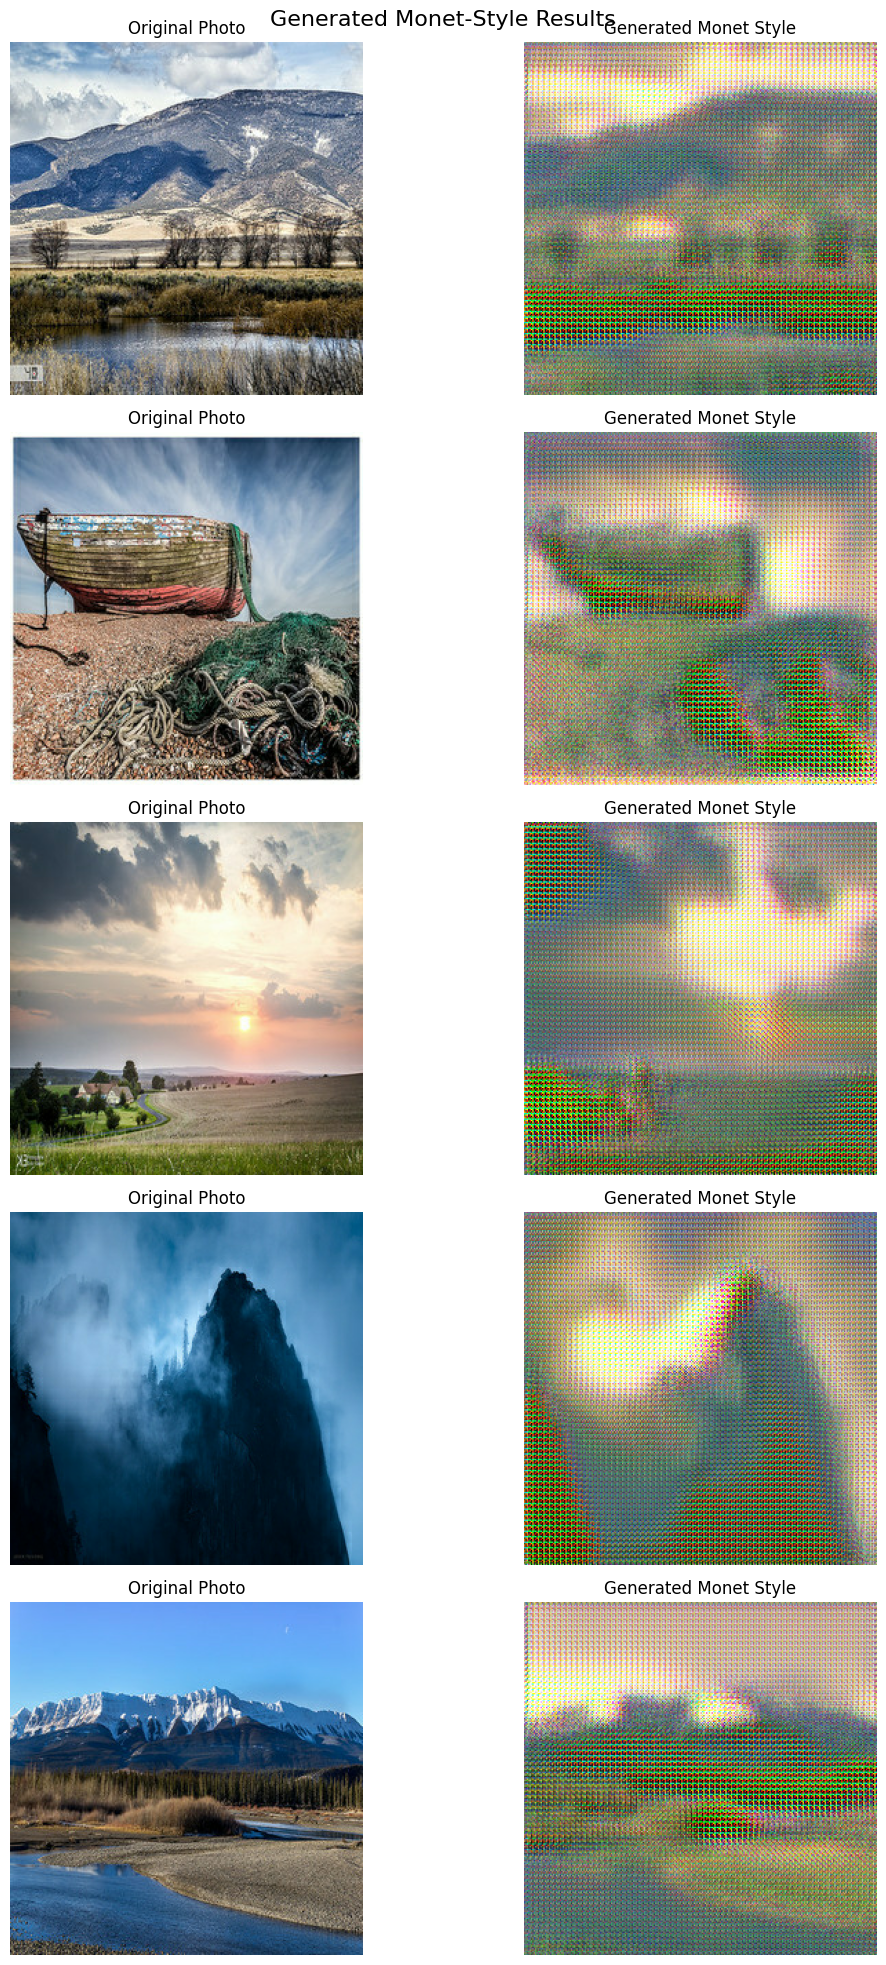

In [26]:
show_generated_samples(photo_ds, generator_f, num_samples=5)


For better quality images, number of epochs can be increased.

# 12.Submissions

In [ ]:
#This section of code is adapted from AnthonyTherrien's notebook.
zip_name = 'images.zip'
with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as z:
    for path in sorted(glob.glob(os.path.join(OUTPUT_DIR, '*.jpg'))):
        z.write(path, arcname=os.path.basename(path))
print('Wrote zip:', zip_name)

#MIFID Score: 141

# 13.Conclusion

This dataset has been trained on the CYCLEGAN model which has ResNet based Generator(encoder-residual-decoder) and PatchGen discriminator.Model has been trained for 20 epochs and validation loss has been calculated for each step. This shows how the model and the discriminator are performing.

- Generator Loss
  G starts at 12.6 and then drop to 6.0
  F starts at 14.0 and then drops to 7.7
  This steady decline how the generators are learning to reconstruct the monet style images.
  
- Discriminator Loss
  Dx drops from 2.15 to 0.57
  Dy fluctates but ends at 1.65
This means discriminators are better at spotting fakes.

- Cycle Consistency Loss
  Cycle G and Cycle F losses starts to drops which indicates the model is learning better.

All the above losses suggset that the model is trying to learn better.

Kaggle evaluates the dataset using MIFID which is a modification of FID score.The smaller the value the better. This model produced MIFID score of 141.

7038 Monet style images are generated and the inages can be found that its not of top quality.

Furthur steps to improve CYCLEGAN model:

- Save checkpoints and compare generator outputs at at epochs 20,30,40
- Increase the number of epochs to generate refined and sharper quality quality images
- Visualize outputs across epochs to correlate metrics with higher quality.

  


# 14.References

1.https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial#Introduction-and-Setup

2.https://www.geeksforgeeks.org/deep-learning/how-to-inspect-a-tensorflow-tfrecord-file/

3.https://www.kaggle.com/code/anthonytherrien/i-m-something-of-a-painter-myself-trainer/notebook#5)-CycleGAN-Architecture

4.https://www.geeksforgeeks.org/deep-learning/residual-networks-resnet-deep-learning/


# 15.Acknowledgement

This project builds upon the work of AnthonyTherrien, whose approach and implementation provided valuable guidance throughout my development process. I followed several of the same steps and incorporated select sections of his code, which I’ve individually cited with inline comments near the relevant parts of my notebook. I sincerely thank him for sharing his work — it played a key role in helping me complete this project. The original notebook is linked in the References section.
